In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jiniiiii/jini...png


Processing for r = 50...
RMSE (r=50): 0.04976845160126686
PSNR (r=50): 26.060917416779695 dB


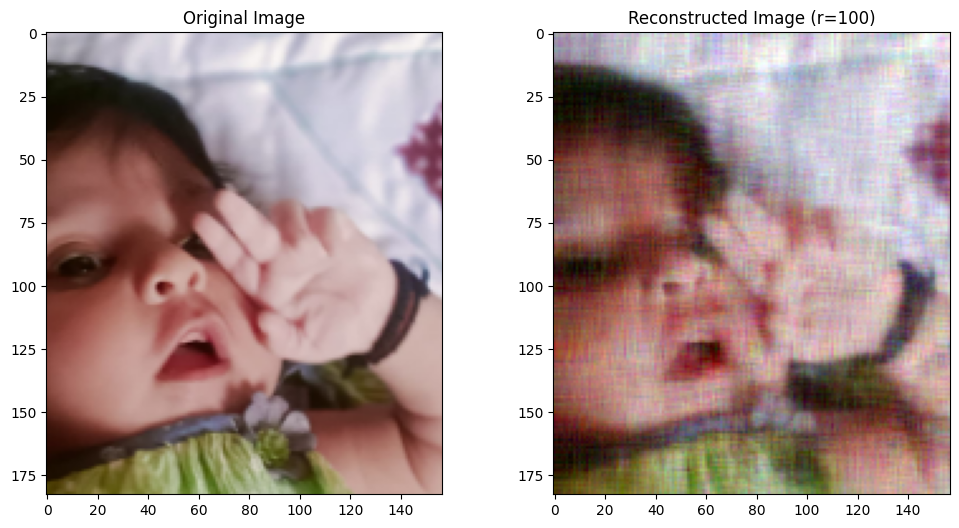

Processing for r = 100...
RMSE (r=100): 0.03523747995495796
PSNR (r=100): 29.059903163423428 dB


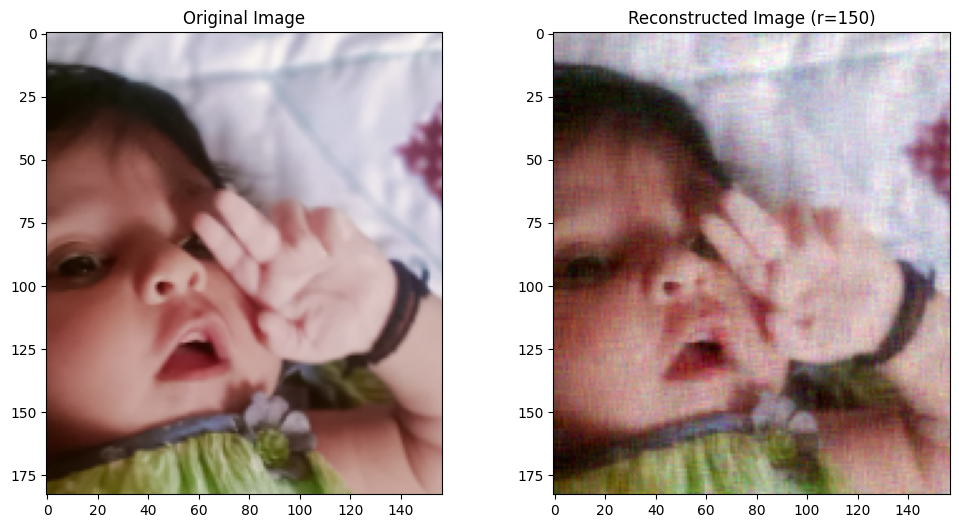

Processing for r = 150...
RMSE (r=150): 0.026056669652462006
PSNR (r=150): 31.681621859947555 dB


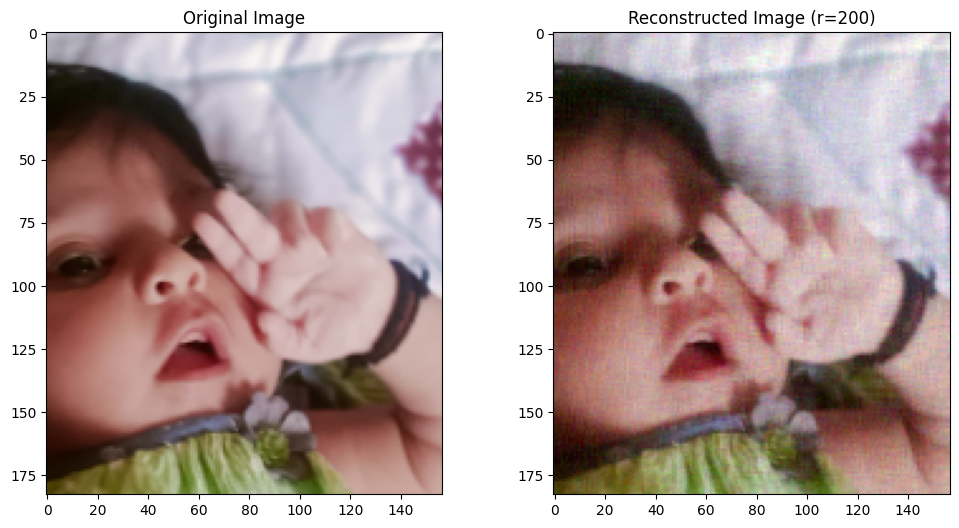

Processing for r = 200...
RMSE (r=200): 0.018177960067987442
PSNR (r=200): 34.80909709876539 dB


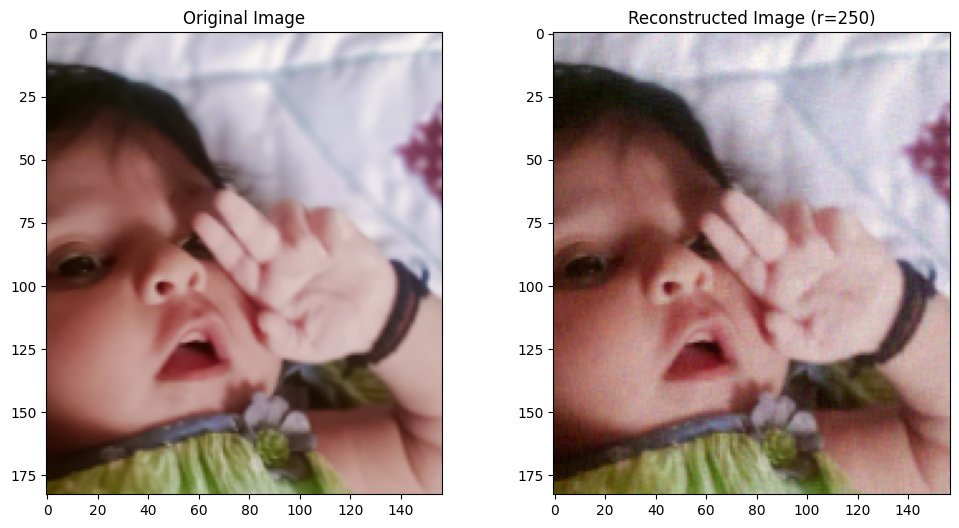

Processing for r = 250...
RMSE (r=250): 0.01220517698675394
PSNR (r=250): 38.26911837030529 dB


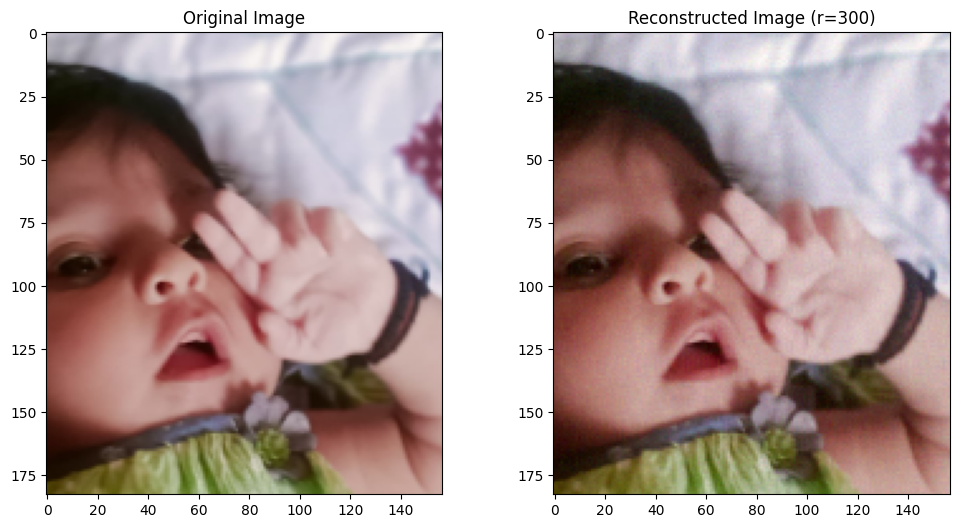

Processing for r = 300...
RMSE (r=300): 0.005911520682275295
PSNR (r=300): 44.566015732731145 dB


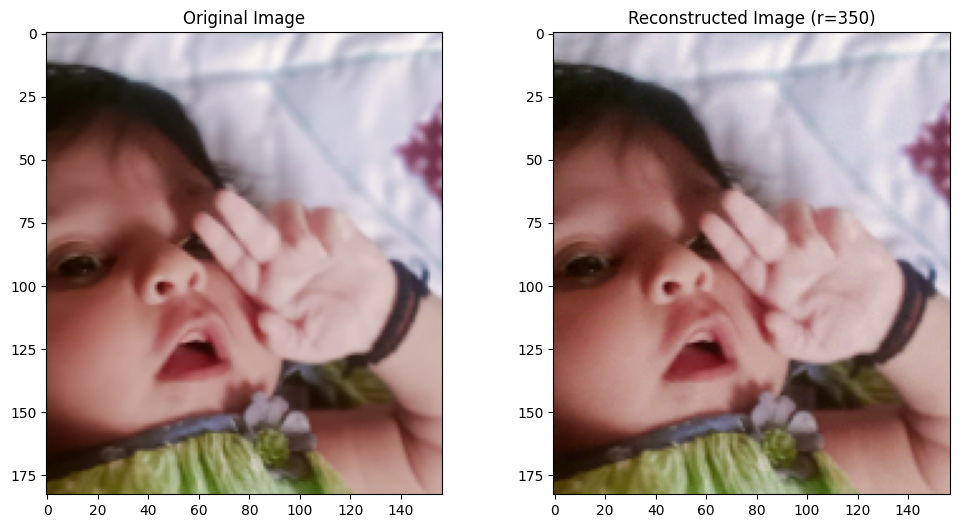

Processing for r = 350...
RMSE (r=350): 0.0007852958515286446
PSNR (r=350): 62.09933393565944 dB


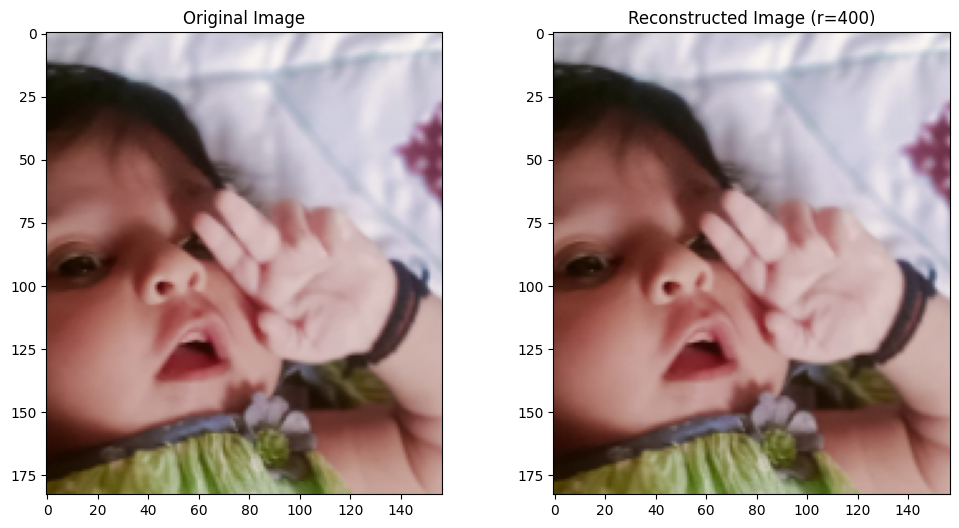

Processing for r = 400...
RMSE (r=400): 0.00031297001987695694
PSNR (r=400): 70.08994525070695 dB


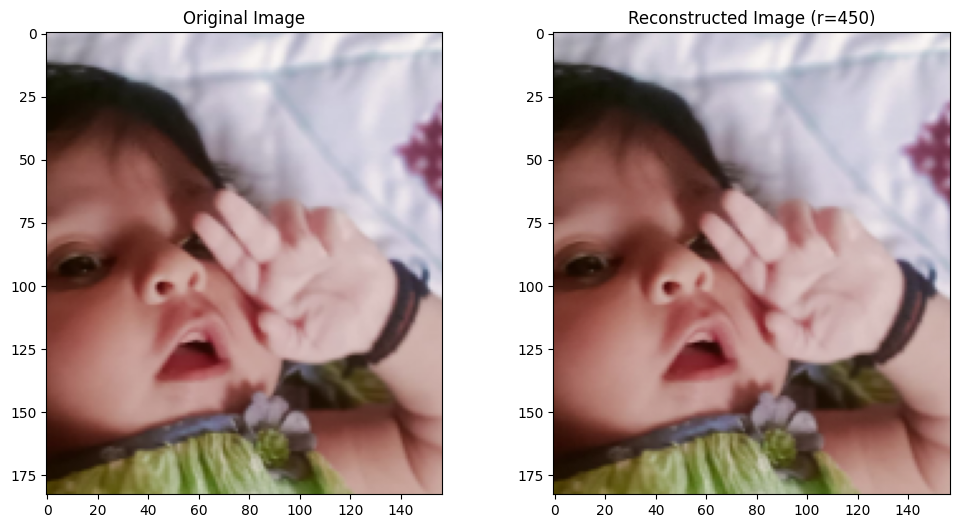

Processing for r = 450...
RMSE (r=450): 0.00021331023890525103
PSNR (r=450): 73.41976595774105 dB
Convergence reached with r = 450


In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_path = '/kaggle/input/jiniiiii/jini...png'
img = torchvision.io.read_image(img_path).float() / 255.0
img = img.to(device)

def factorize_ch(ch, r, lr=0.01, num_iters=3000):
    h, w = ch.shape
    W = torch.randn(h, r, requires_grad=True, device=device)
    H = torch.randn(r, w, requires_grad=True, device=device)
    opt = torch.optim.Adam([W, H], lr=lr)

    prev_loss = float('inf')
    for i in range(num_iters):
        opt.zero_grad()
        recon_ch = torch.mm(W, H)
        loss = torch.norm(recon_ch - ch, 'fro') ** 2
        loss.backward()
        opt.step()
        
        # Check convergence
        if abs(prev_loss - loss.item()) < 1e-4:  # Change this threshold as needed
            break
        prev_loss = loss.item()

    return W, H, loss.item()

def calculate_rmse(orig, recon):
    return np.sqrt(np.mean((orig - recon) ** 2))

def calculate_psnr(orig, recon):
    mse = np.mean((orig - recon) ** 2)
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

# Initialize variables for convergence
r = 50
convergence_threshold = 1e-4
prev_rmse = float('inf')

while True:
    recon_channels = []
    print(f"Processing for r = {r}...")

    for c in range(img.shape[0]):
        ch = img[c, :, :]
        W, H, loss = factorize_ch(ch, r)
        recon_ch = torch.mm(W, H).cpu().detach().numpy()
        recon_channels.append(recon_ch)

    recon_img = np.stack(recon_channels, axis=0)
    recon_img = np.transpose(recon_img, (1, 2, 0))
    orig_img = img.cpu().detach().numpy()
    orig_img = np.transpose(orig_img, (1, 2, 0))

    rmse = calculate_rmse(orig_img, recon_img)
    psnr = calculate_psnr(orig_img, recon_img)

    print(f"RMSE (r={r}): {rmse}")
    print(f"PSNR (r={r}): {psnr} dB")
    
    # Check for convergence
    if abs(prev_rmse - rmse) < convergence_threshold:
        print(f"Convergence reached with r = {r}")
        break

    prev_rmse = rmse
    r += 50  # Increment r as needed (e.g., by 50)

    # Plot original and reconstructed images for current r
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(orig_img)
    ax[0].set_title(f'Original Image')
    ax[1].imshow(recon_img)
    ax[1].set_title(f'Reconstructed Image (r={r})')
    plt.show()
